## Description
In this notebook, I use an image (manually generated in GIMP) to generate a simulated MSI dataset with overlapping isotopic envelopes.  
I'll create two images, one with lipids and one with synthetic polymers (spectra generated in IsoSpec).  
Each image also has a certain level of noise signal - random peaks, as well as contaminant molecules.  

Simulation steps:  
1. Generate reference spectra for different regions of the image using manually selected proportions
2. For each pixel, distort the reference proportions of the spectra (depending on the corresponding region); Distort each spectrum by sampling from the multinomial process with the number of molecules given by the corresponding distorted proportion; Combine the distorted spectra; Add a handful of noise peaks amounting for 5% of the total signal to simulate contaminants; Apply a Gaussian filter to the spectra to lower the resolution; Apply a Gaussian distortion to each intensity measurement to simulate electronic noise; Centroid the spectra.  

The result is stored in imzML files.  

## Module & data imports

In [349]:
%matplotlib notebook

In [350]:
import imageio
import numpy as np
import numpy.random as rd 
from masserstein import Spectrum, estimate_proportions
from matplotlib import pyplot as plt
from pyimzml.ImzMLWriter import ImzMLWriter

In [351]:
mask = imageio.imread('SimulationMask.png')

<IPython.core.display.Javascript object>


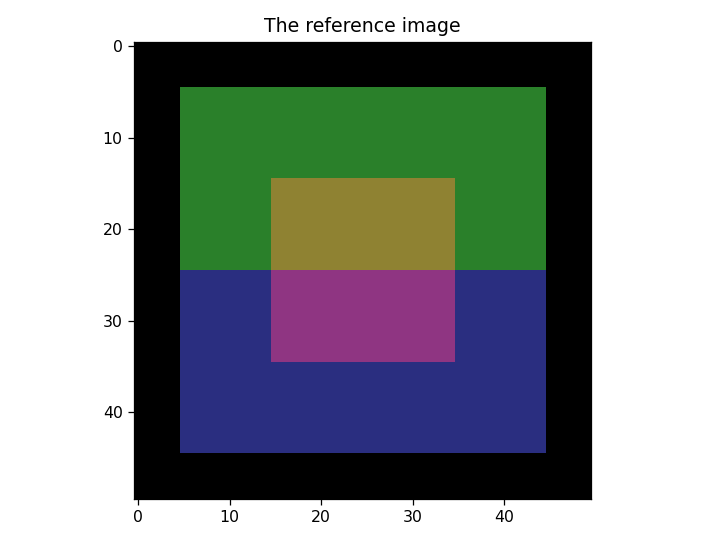

In [352]:
plt.figure()
plt.title('The reference image')
plt.imshow(mask)
plt.tight_layout()
plt.show()

In [353]:
np.unique(mask[:,:,1])

Array([  0,  46,  53, 128, 130], dtype=uint8)

In [354]:
region1 = mask[:,:,1] == 128
region2 = mask[:,:,1] == 130
region3 = mask[:,:,1] == 46
region4 = mask[:,:,1] == 53

In [355]:
region_mapping = np.zeros(mask.shape[:2], dtype='int')
for reg_id, reg_value in enumerate([0, 128, 130, 46, 53]):
    region_mapping[mask[:,:,1] == reg_value] = reg_id

<IPython.core.display.Javascript object>


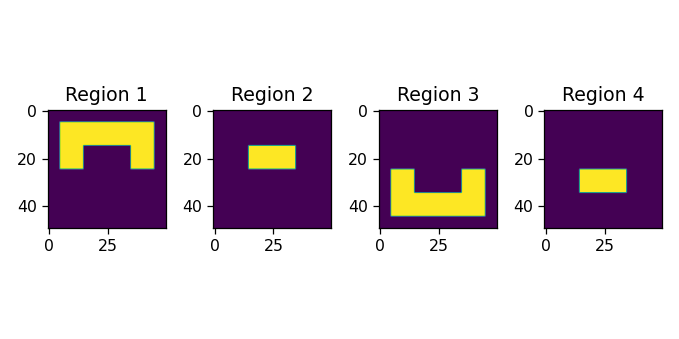

In [356]:
plt.figure(figsize=(6,3))
plt.subplot(141)
plt.title('Region 1')
plt.imshow(region1)
plt.subplot(142)
plt.title('Region 2')
plt.imshow(region2)
plt.subplot(143)
plt.title('Region 3')
plt.imshow(region3)
plt.subplot(144)
plt.title('Region 4')
plt.imshow(region4)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


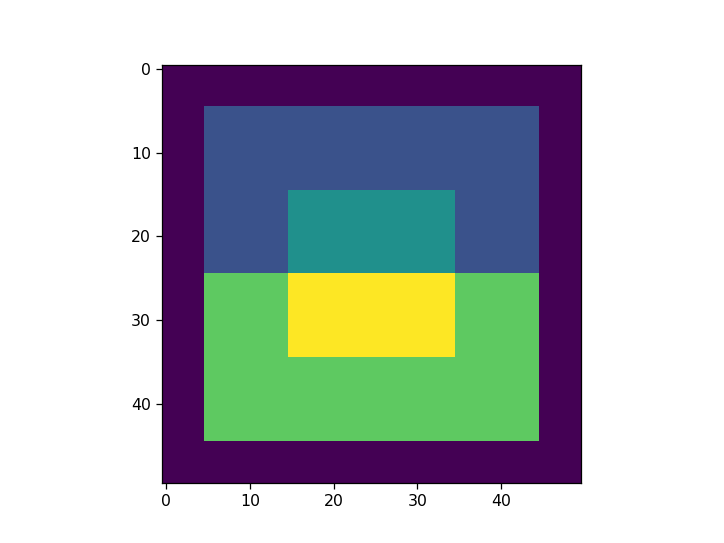

In [357]:
plt.figure()
plt.imshow(region_mapping)
plt.show()

## Lipid dataset

In [358]:
# PC_38_0 = 'C46H92NO8P'
# PC_38_1 = 'C46H90NO8P'
# PC_38_2 = 'C46H88NO8P'
# PC_38_3 = 'C46H86NO8P'

# PS_38_1 = 'C44H84NO10P'
# PS_38_3 = 'C44H80NO10P'
# PS_38_4 = 'C44H78NO10P'
# PS_38_5 = 'C44H76NO10P'
# PS_38_6 = 'C44H74NO10P'

# formulas = [PC_38_0, PC_38_1, PC_38_2, PC_38_3, PS_38_3, PS_38_4, PS_38_5, PS_38_6]
# formulas = [PC_38_0, PC_38_1, PC_38_2, PC_38_3, PS_38_4]

In [359]:
TG_50_8 = 'C53H86O6'    # 857.5
PC_38_0 = 'C46H92NO8P'  # 856.6 
PC_38_1 = 'C46H90NO8P'  # 854.5
PS_38_0 = 'C44H86NO10P' # 858.5
PA_44_0 = 'C47H93O8P'   # 855.6

In [360]:
formulas = [PC_38_1, PA_44_0, PC_38_0, TG_50_8, PS_38_0]
names = ['PC(38:1)', 'PA(44:0)', 'PC(38:0)', 'TG(50:8)', 'PS(38:0)']
spectra = [Spectrum(f, adduct='K', threshold=0.001, label=n) for f, n in zip(formulas, names)]
for s in spectra:
    s.normalize()

Monoisotopic peaks:

In [361]:
for s in spectra:
    print(s.confs[0][0])

854.6041123617
855.62451345431
856.61976242624
857.60614698942
858.56264147302


Save the lipid table:

In [362]:
with open('lipid_table.tsv', 'w') as h:
    h.write('\t'.join(['Name', 'Formula', 'Monoisotopic mass']) + '\n')
    for s in spectra:
        h.write(s.label + '\t' + s.formula + '\t' + str(s.confs[0][0]) + '\n')

In [363]:
# for s in spectra:
#     s.coarse_bin(1)
#     print(s.confs)

<IPython.core.display.Javascript object>


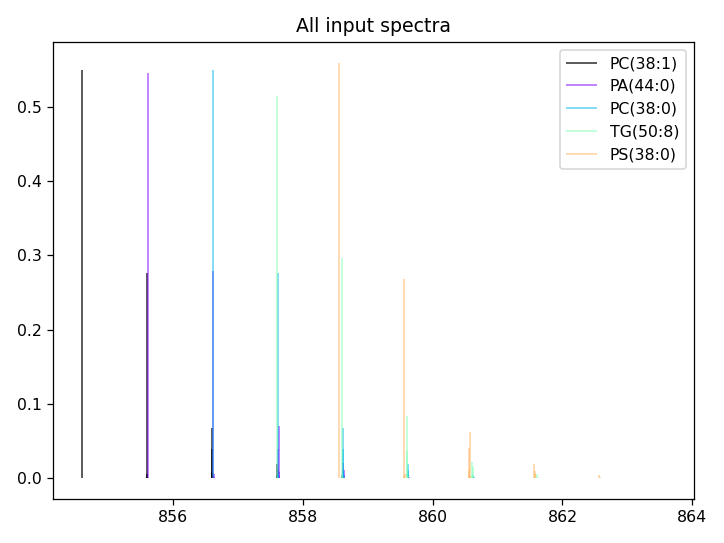

In [364]:
plt.figure()
plt.title('All input spectra')
Spectrum.plot_all(spectra)
plt.tight_layout()
plt.show()

Set the proportions for the regions.  
We should probably make some lipids disappear in some regions to make them distinguishable.  

Strategy:  
Regions 3,4 enriched in PC(38:1).  
Regions 1,2 enriched in PA(44:0) with monoisotopic peak at 855.6, but intensity of 855.6 depleted due to interference with PC(38:1) in 3,4.    
Regions 2,4 enriched in PC(38:0) with monoisotopic peak at 856.6, but intensity of 856.6 shows multiple regions due to overlap from PA(44:0) in 1,2.  


In [365]:
# region_intensities = np.array([[0.00, 0.00,  0.00, 0.01, 0.02],
#                                [2.50, 0.00,  0.00, 0.02, 0.01],
#                                [2.50, 0.00,  0.50, 0.02, 0.01],
#                                [0.00, 1.00,  0.50, 0.02, 0.01],
#                                [0.00, 1.00,  0.00, 0.02, 0.01]])

region_intensities = np.array([[0.00, 0.00,  0.00, 0.1, 0.2],  # rows = regions (including background as 0)
                               [0.00, 2.00,  1.00, 0.2, 0.1],  # columns = lipids
                               [0.00, 2.00,  2.00, 0.2, 0.1],
                               [4.00, 1.00,  1.00, 0.2, 0.1],
                               [4.00, 1.00,  2.00, 0.2, 0.1]])

Save the reference intensity image:

In [366]:
region_intensities[region_mapping, 0].shape

(50, 50)

<IPython.core.display.Javascript object>


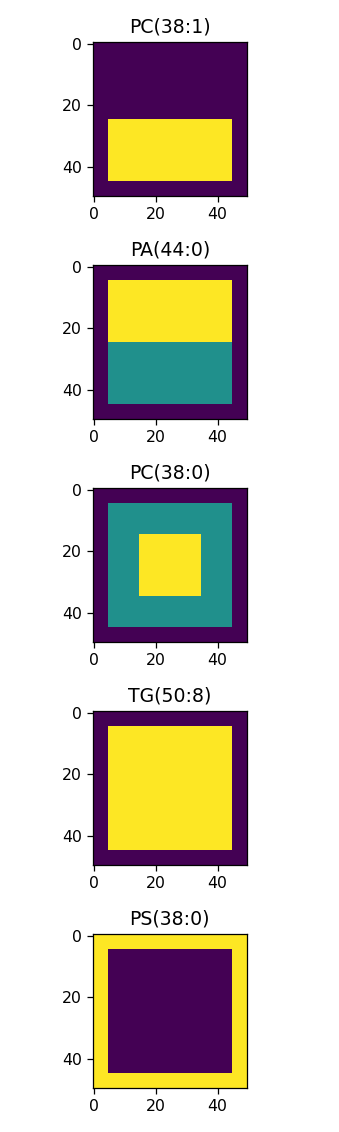

In [367]:
plt.figure(figsize=(3, 2*len(spectra)))
for lipid_id, lipid_name in enumerate(names):
    plt.subplot(511 + lipid_id)
    spatial_intensity = region_intensities[region_mapping, lipid_id]
    plt.imshow(spatial_intensity)
    plt.title(lipid_name)
plt.tight_layout()
plt.savefig('lipid_enrichment_plot.pdf')

<IPython.core.display.Javascript object>


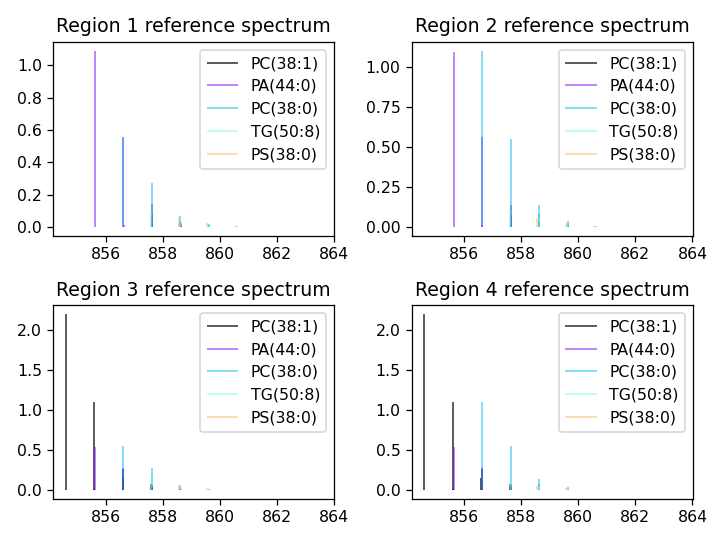

In [368]:
plt.figure()
for i in range(1, region_intensities.shape[0]): 
    plt.subplot(220 + i)
    plt.title('Region %i reference spectrum' % i)
    Spectrum.plot_all([s*p for s,p in zip(spectra, region_intensities[i])])
plt.tight_layout()
plt.show()

Generate distorted reference spectra:

In [369]:
noise_proportion = 0.05
nb_of_noise_peaks = 10
nb_of_molecules = 1e04

peak_sd = 0.05

mass_axis = np.arange(854, 865, 0.01)

In [370]:
reference_spectra = [Spectrum() for _ in range(region_intensities.shape[0])]
for i in range(region_intensities.shape[0]):
    for j in range(region_intensities.shape[1]):
        reference_spectra[i] += Spectrum.sample_multinomial(spectra[j], 
                                                            region_intensities[i,j]*nb_of_molecules, 
                                                            1, 0.001)
    reference_spectra[i].add_chemical_noise(nb_of_noise_peaks, noise_proportion)
    reference_spectra[i].fuzzify_peaks(peak_sd, 0.01)
    reference_spectra[i] = reference_spectra[i].resample(mass_axis)
    #reference_spectra[i].add_gaussian_noise(20)
    reference_spectra[i].confs = [c for c in reference_spectra[i].confs if c[1] >= 0]
max_intensity = max(y for s in reference_spectra for x,y in s.confs)

<IPython.core.display.Javascript object>


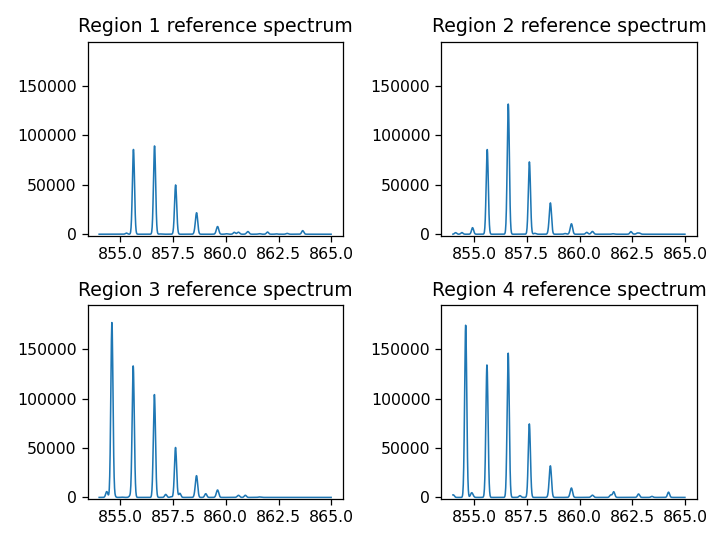

In [371]:
plt.figure()
for i in range(1, region_intensities.shape[0]): 
    plt.subplot(220 + i)
    plt.title('Region %i reference spectrum' % i)
    reference_spectra[i].plot(profile=True)
    plt.ylim(-0.01*max_intensity, 1.1*max_intensity)
plt.tight_layout()
plt.show()

Centroid the spectrum for estimation:

In [372]:
region = 3 

In [373]:
example_spectrum = Spectrum(confs=reference_spectra[region].centroid(0.2, 0.4)[0])

<IPython.core.display.Javascript object>


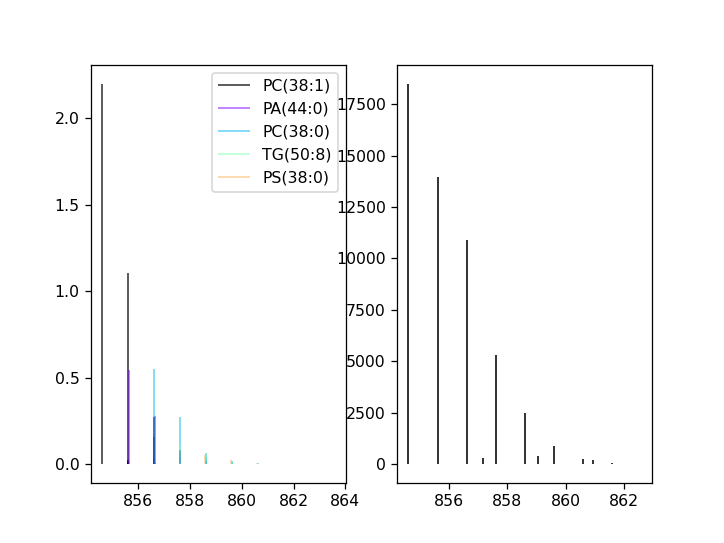

In [374]:
plt.figure()
plt.subplot(121)
Spectrum.plot_all([s*p for s,p in zip(spectra, region_intensities[region])])
plt.subplot(122)
example_spectrum.plot(profile=False)
plt.show()

Estimate the proportions based on monoisotopic peaks:

In [375]:
mono_peaks = [s.confs[0][0] for s in spectra]
mono_intensities = np.zeros(len(mono_peaks))

In [376]:
for i, p in enumerate(mono_peaks):
    match = np.argmin([np.abs(p - c[0]) for c in example_spectrum.confs])
    if np.abs(p-example_spectrum.confs[match][0]) < 0.05:
        mono_intensities[i]  = example_spectrum.confs[match][1]
mono_intensities /= np.sum(mono_intensities)

In [377]:
mono_intensities

array([0.36130541, 0.27295135, 0.2131801 , 0.10370674, 0.0488564 ])

Test the regression:

In [378]:
example_spectrum.normalize()

In [379]:
# reg = estimate_proportions(example_spectrum, spectra, MTD=0.05)  # for centroided
reg = estimate_proportions(example_spectrum, spectra, MTD=0.4)  # for profile

In [380]:
print('True', 'Regressed', 'Monoisotopic')
for t, e1, e2 in zip(region_intensities[region]/sum(region_intensities[region]), reg['proportions'], mono_intensities):
    print(round(t, 3), round(e1, 3), round(e2, 3))

True Regressed Monoisotopic
0.635 0.631 0.361
0.159 0.151 0.273
0.159 0.155 0.213
0.032 0.028 0.104
0.016 0.019 0.049


Now, go over each pixel and simulate the spectra:

In [381]:
image = np.zeros((mask.shape[0], mask.shape[1], len(mass_axis)))
for i in range(mask.shape[0]):
    if not i % 50:
        print(i)
    for j in range(mask.shape[1]):
        region_id = region_mapping[i, j]
        proportions = region_intensities[region_id]
        pixel_spectrum = Spectrum()
        for s,p in zip(spectra, proportions):
            s = Spectrum.sample_multinomial(s, p*nb_of_molecules, 1, 0.001)
            pixel_spectrum += s*p
        pixel_spectrum.add_chemical_noise(nb_of_noise_peaks, noise_proportion)
        pixel_spectrum.fuzzify_peaks(peak_sd, 0.01)
        pixel_spectrum = pixel_spectrum.resample(mass_axis)
        # pixel_spectrum.add_gaussian_noise(100)
        pixel_spectrum.set_confs([c for c in pixel_spectrum.confs if c[1] >= 0])
        image[i,j,:] = [y for x,y in pixel_spectrum.confs]

0


Save the image in profile mode in imzML:

In [382]:
with ImzMLWriter('lipid_MSI_profile_mode.imzML') as writer:
    for i in range(mask.shape[0]):
        if not i % 50:
            print(i)
        for j in range(mask.shape[1]):
            writer.addSpectrum(mass_axis, image[i,j,:], (i, j))

0


Centroid the image and save it in imzML:

In [383]:
with ImzMLWriter('lipid_MSI_centroid_mode.imzML') as writer:
    for i in range(mask.shape[0]):
        if not i % 50:
            print(i)
        for j in range(mask.shape[1]):
            S = Spectrum(confs=list(zip(mass_axis, image[i,j,:])))
            peaks, _ = S.centroid(0.25, 0.4)
            mzs = [p[0] for p in peaks]
            intsys = [p[1] for p in peaks]
            writer.addSpectrum(mzs, intsys, (i, j))

0


## Data validation

In [384]:
from pyimzml.ImzMLParser import ImzMLParser

In [385]:
profile_image = ImzMLParser('lipid_MSI_profile_mode.imzML')
centroid_image = ImzMLParser('lipid_MSI_centroid_mode.imzML')

In [386]:
profile_ion_image = np.zeros(mask.shape[:2])
centroid_ion_image = np.zeros(mask.shape[:2])

In [387]:
# peak_to_plot = 856.626  # PC_38_0
 peak_to_plot = 855.68  # PA_44_0
# peak_to_plot = 852.525    # PC_38_2 and PS_38_3
# peak_to_plot = 850.53    # PC_38_3 and PS_38_4

In [388]:
for i, (x,y,z) in enumerate(profile_image.coordinates):
    mz, intsy = profile_image.getspectrum(i)
    mz = np.array(mz)
    peak_id = np.argmin(np.abs(mz-peak_to_plot))
    profile_ion_image[x, y] = intsy[peak_id]
    mz, intsy = centroid_image.getspectrum(i)
    mz = np.array(mz)
    peak_id = np.argmin(np.abs(mz-peak_to_plot))
    centroid_ion_image[x, y] = intsy[peak_id]

<IPython.core.display.Javascript object>


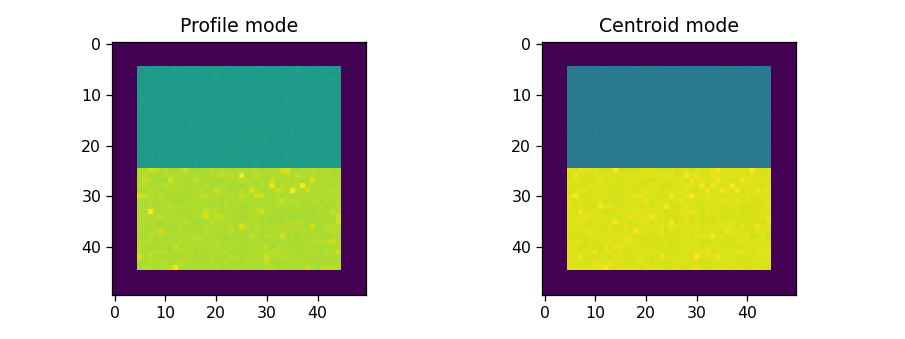

In [389]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.title('Profile mode')
plt.imshow(profile_ion_image)
plt.subplot(122)
plt.title('Centroid mode')
plt.imshow(centroid_ion_image)
plt.tight_layout()
plt.show()

## Estimation of optimal MTD based on selected pixels

In [390]:
px = (20, 20)
print('pixel', px, 'from region', region_mapping[px])

pixel (20, 20) from region 2


<IPython.core.display.Javascript object>


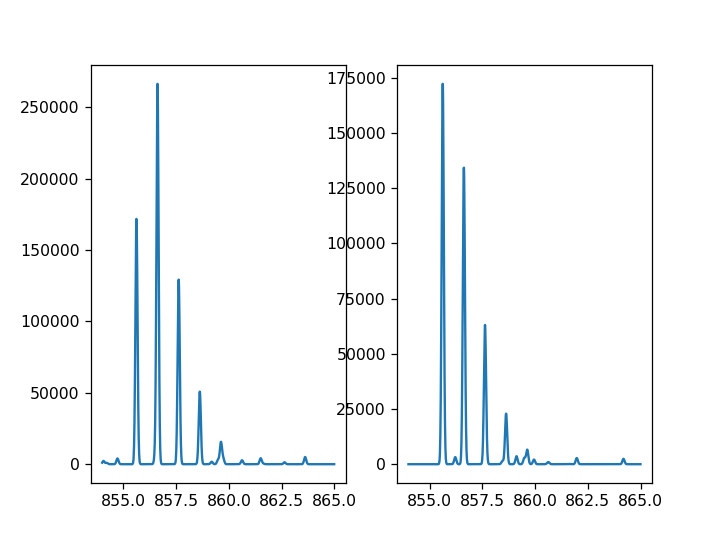

In [391]:
plt.figure()
plt.subplot(121)
plt.plot(mass_axis, image[20, 20,:])
plt.subplot(122)
plt.plot(mass_axis, image[20, 10,:])
plt.show()

In [392]:
S1 = Spectrum(confs=list(zip(mass_axis, image[20,10,:])))
T1 = np.trapz(image[20,10,:], mass_axis)
S1.normalize()
S2 = Spectrum(confs=list(zip(mass_axis, image[20,20,:])))
T2 = np.trapz(image[20,20,:], mass_axis)
S2.normalize()

In [393]:
C1 = Spectrum(confs=S1.centroid(0.25, 0.4)[0])
C1.normalize()
C2 = Spectrum(confs=S2.centroid(0.25, 0.4)[0])
C2.normalize()

In [394]:
R1 = estimate_proportions(S1, spectra, MTD=0.2)
R2 = estimate_proportions(S2, spectra, MTD=0.2)

In [395]:
for ptrue, pestim in zip(region_intensities[1], R1['proportions']):
    print(ptrue, round(pestim*sum(region_intensities[1]), 2))

0.0 -0.0
2.0 2.48
1.0 0.63
0.2 0.04
0.1 0.02


In [396]:
for ptrue, pestim in zip(region_intensities[2], R2['proportions']):
    print(ptrue, round(pestim*sum(region_intensities[2]), 2))

0.0 0.04
2.0 2.0
2.0 2.06
0.2 -0.0
0.1 0.01


Estimate MTD based on Region 2:

In [397]:
mtd_array = np.linspace(0.01, 1., num=400)
correlations_P = np.zeros(mtd_array.shape)
l1_P = np.zeros(mtd_array.shape)  # profile
correlations_C = np.zeros(mtd_array.shape)
l1_C = np.zeros(mtd_array.shape)  # centroid

In [398]:
for i, mtd in enumerate(mtd_array):
    R2 = estimate_proportions(S2, spectra, MTD=mtd)
    p2 = np.array(R2['proportions'])*sum(region_intensities[2])
    l1_P[i] = sum(np.abs(p2 - region_intensities[2]))
    correlations_P[i] = np.corrcoef(region_intensities[2], p2)[0,1]
    
    R2 = estimate_proportions(C2, spectra, MTD=mtd)
    p2 = np.array(R2['proportions'])*sum(region_intensities[2])
    l1_C[i] = sum(np.abs(p2 - region_intensities[2]))
    correlations_C[i] = np.corrcoef(region_intensities[2], p2)[0,1]

<IPython.core.display.Javascript object>


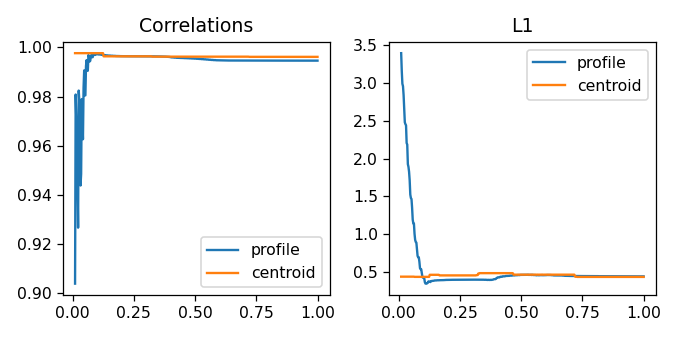

In [399]:
plt.figure(figsize=(6,3))
plt.subplot(121)
plt.title('Correlations')
plt.plot(mtd_array, correlations_P)
plt.plot(mtd_array, correlations_C)
plt.legend(['profile', 'centroid'])
plt.subplot(122)
plt.title('L1')
plt.plot(mtd_array, l1_P)
plt.plot(mtd_array, l1_C)
plt.legend(['profile', 'centroid'])
plt.tight_layout()
plt.show()

In [400]:
region_intensities[2]/sum(region_intensities[2])

array([0.        , 0.46511628, 0.46511628, 0.04651163, 0.02325581])

In [401]:
np.corrcoef(R2['proportions'], region_intensities[2])

array([[1.        , 0.99615514],
       [0.99615514, 1.        ]])